<a href="https://colab.research.google.com/github/LukeHaberkamp/tensorflow-timeseries-essentials/blob/main/C_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook trains a neural network to remove gaussian noise from timeseries data

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam

Using the logistic equation to generate timeseries data

In [ ]:
# function to create sample data using the logistic equation
def logisticEq(r, x0, N):
    x = [x0]
    for i in range(1, N):
        x_new = r * x[i-1] * (1 - x[i-1])
        x.append(x_new)
    return np.array(x)

Generate the sample data. It is necessary to add a dimension to the data to define a sequence. An r of 3.5 gives stable-periodic data.

In [ ]:
# Generate sample data 
samples = np.arange(0, 10000)

r = 3.5
x0 = 0.3
N = len(samples)

data = logisticEq(r=r, x0=x0, N = N) * 5
data = np.expand_dims(data, axis=1) # add dimension to define 1D data

Functions to embed the data and plot for visualization of the phase portrait

In [ ]:
def TDE(x, m, tau):
    emb = np.zeros((len(x)-m*tau, m))
    for i in range(m):
        emb[:,i] = x[i*tau:(i*tau + (len(x)-m*tau))]
    return emb

In [ ]:
def statespaceplot(x):
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    if x.shape[1] > 2:
        ax = plt.axes(projection='3d')
        ax.scatter3D(x[:,0], x[:,1], x[:,2], alpha=0.7)
    else:
        ax = plt.axes()
        ax.scatter(x[:,0], x[:,1], alpha=0.7)
    ax.set_title('State Space')
    ax.set_xlabel("X")
    ax.set_ylabel("X'")
    ax.set_zlabel('X"')
    plt.show()

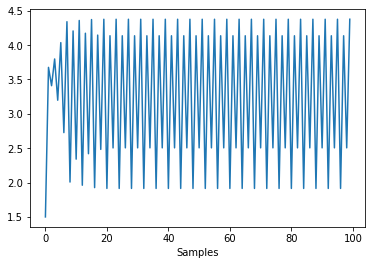

In [ ]:
plt.plot(samples[:100], data[:100])
plt.xlabel("Samples")
plt.show()

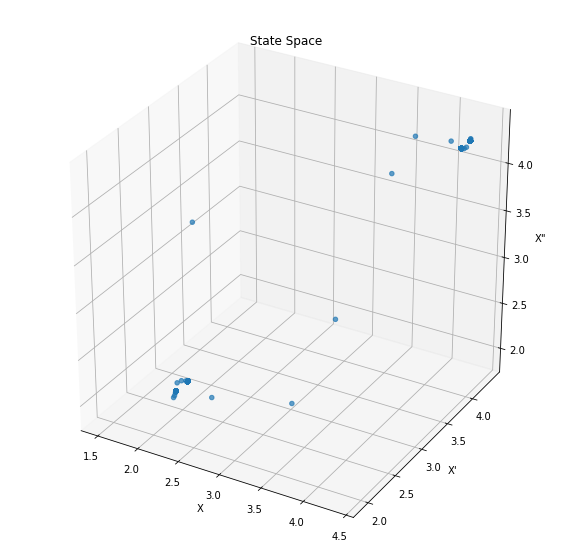

In [ ]:
tde_data = TDE(data.squeeze(), m=3, tau=2)
statespaceplot(tde_data)

Generate data that adds noise to the original time-series data. The noise has a normal distribution with mean = 0 and a SD = 0.5 * SD(data)

In [ ]:
noise = np.random.normal(0, 0.5*np.std(data), data.shape[0])
noise = np.expand_dims(noise, axis=1)

noisy_data = noise + data

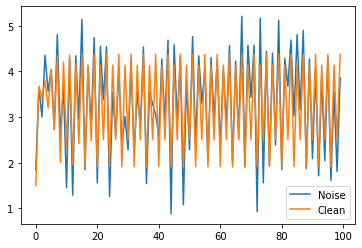

In [ ]:
plt.plot(noisy_data[:100])
plt.plot(data[:100])
plt.legend(['Noise', 'Clean'])
plt.show()

To prevent vanishing/expoding gradients we scale the data before into the network. StandardScaler (x - mean / std) or MinMaxScaler ((x - min) / (max - min)) work well. This is crucial for multivariate datasets.
  
We are using MinMaxScaler 

In [ ]:
scaler = MinMaxScaler()
scaled_y = scaler.fit_transform(data)
scaled_x = scaler.transform(noisy_data)

Window the dataset to generate training data. The "x" data are the model inputs with added noise. The "y" data are the ground truth data without noise.

In [ ]:
window_size = 32

x = []
y = []
for i in range(window_size, scaled_x.shape[0]):
    x.append(scaled_x[i-window_size:i])
    y.append(scaled_y[i-window_size:i])

x = np.array(x)
y = np.array(y)

In [ ]:
cutoff = round(0.8 * x.shape[0])

x_train = x[:cutoff]
y_train = y[:cutoff]

x_val = x[cutoff:]
y_val = y[cutoff:]

print("Training Inputs Shape:", x_train.shape)
print("Training Outputs Shape:", y_train.shape)

print("\nValidation Inputs Shape:", x_val.shape)
print("Validation Outputs Shape:", y_val.shape)

Training Inputs Shape: (7974, 32, 1)
Training Outputs Shape: (7974, 32, 1)

Validation Inputs Shape: (1994, 32, 1)
Validation Outputs Shape: (1994, 32, 1)


In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

Build an LSTM Autoencoder

In [ ]:
inputs = Input(shape=(None, x.shape[-1]))

h = LSTM(16, return_sequences=True)(inputs)
h = LSTM(5, return_sequences=True)(h)
h = LSTM(16, return_sequences=True)(h)

outputs = TimeDistributed(Dense(1))(h)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 lstm (LSTM)                 (None, None, 16)          1152      
                                                                 
 lstm_1 (LSTM)               (None, None, 5)           440       
                                                                 
 lstm_2 (LSTM)               (None, None, 16)          1408      
                                                                 
 time_distributed (TimeDistr  (None, None, 1)          17        
 ibuted)                                                         
                                                                 
Total params: 3,017
Trainable params: 3,017
Non-trainable params: 0
___________________________________________________________

Compile and train the model

In [ ]:
optimizer = Adam(learning_rate=1e-3)
loss = 'mse'
model.compile(loss=loss, optimizer=optimizer)

In [ ]:
history = model.fit(x_train,y_train,
            validation_data=(x_val,y_val),
            epochs=20,
            shuffle=True,
            batch_size=32,
            verbose=1)

Epoch 1/20
250/250 [==============================] - 24s 44ms/step - loss: 0.1689 - val_loss: 0.1388
Epoch 2/20
250/250 [==============================] - 9s 35ms/step - loss: 0.0601 - val_loss: 0.0150
Epoch 3/20
250/250 [==============================] - 9s 34ms/step - loss: 0.0108 - val_loss: 0.0082
Epoch 4/20
250/250 [==============================] - 9s 35ms/step - loss: 0.0075 - val_loss: 0.0070
Epoch 5/20
250/250 [==============================] - 9s 35ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 6/20
250/250 [==============================] - 9s 34ms/step - loss: 0.0058 - val_loss: 0.0048
Epoch 7/20
250/250 [==============================] - 9s 34ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 8/20
250/250 [==============================] - 9s 35ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 9/20
250/250 [==============================] - 9s 34ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 10/20
250/250 [==============================] - 9s 35ms/step - loss: 0.0027 - val_l

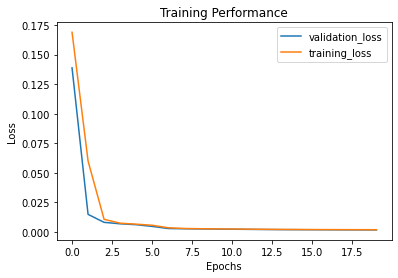

In [ ]:
val_loss = history.history['val_loss']
loss = history.history['loss']

# Obtain number of epochs
epochs = range(len(loss))
# Plot loss and val loss
plt.plot(val_loss, label='validation_loss')
plt.plot(loss, label='training_loss')
plt.legend()
plt.title('Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Evaluate the validation dataset

In [ ]:
y_pred = model.predict(x_val, batch_size=32)

63/63 [==============================] - 2s 8ms/step


Now we will flatten the 3D sequences for our validation dataset/predictions, so we can convert the data back to the original scale (sklearn scalers require 2D arrays). 

In [ ]:
y_val2 = np.expand_dims(y_val.ravel(), axis=1)
y_val2 = scaler.inverse_transform(y_val2)

y_pred2 = np.expand_dims(y_pred.ravel(), axis=1)
y_pred2 = scaler.inverse_transform(y_pred2)

Next we will reshape the arrays back into their 3D form to plot

In [ ]:
y_val2 = y_val2.reshape((1994,32,1))
y_pred2 = y_pred2.reshape((1994,32,1))

Calculate the rmse and plot for predictions vs. ground truth

RMSE = 0.123 



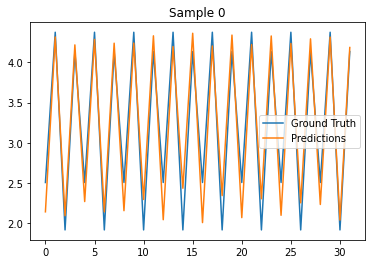

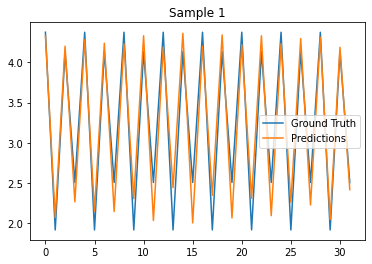

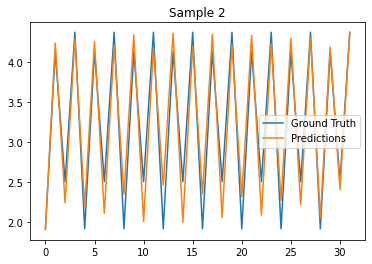

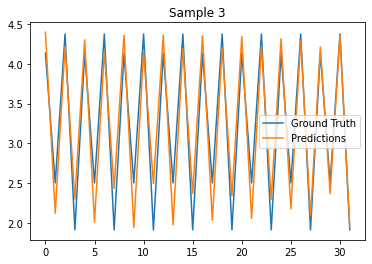

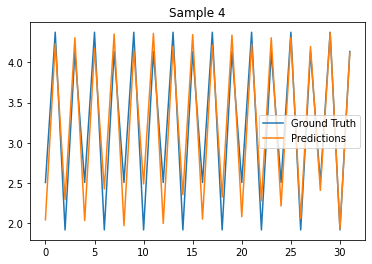

In [ ]:
rmse = np.sqrt( np.mean( (y_val2 - y_pred2)**2 ) )
print("RMSE =", round(rmse,3), "\n")

for i in range(5):
    plt.plot(y_val2[i])
    plt.plot(y_pred2[i])
    plt.legend(['Ground Truth', 'Predictions'])
    plt.title("Sample " + str(i))
    plt.show()